In [2]:
from py2neo import Graph
from py2neo import Node

In [3]:
import pandas as pd

In [17]:
from matplotlib import pyplot as plt

In [8]:
#creates a py2neo database 
from py2neo import Database
db = Database("bolt://disease.ncats.io:80")
#the connection seems to only last for about an hour

In [9]:
#gets the graph object from databse
graph = db.default_graph

In [6]:
#alternatively, we can also get the remote db with the Graph constructer
#graph = Graph("bolt://localhost:7687") 

In [20]:
query = """match (n:S_GARD)--(d:DATA) where d.id = 1 with n, 
d match p =(n)-[:R_rel]-(s:S_HP)--(:DATA) return d.id, s.N_Name
"""

cursor = graph.run(query)

#print the records from the Database.cursor object
for record in cursor:
    print(record)

<Record d.id=1 s.N_Name=['HYPOTONIA, IN NEONATAL ONSET', 'LOW MUSCLE TONE, IN NEONATAL ONSET', 'HYPOTONIA, NEONATAL', 'CONGENITAL HYPOTONIA', 'NEONATAL HYPOTONIA']>
<Record d.id=1 s.N_Name=['INCREASED SERUM PYRUVIC ACID', 'INCREASED SERUM PYRUVATE']>
<Record d.id=1 s.N_Name='CHRONIC LACTIC ACIDOSIS'>
<Record d.id=1 s.N_Name=['AUTOSOMAL RECESSIVE', 'AUTOSOMAL RECESSIVE FORM', 'AUTOSOMAL RECESSIVE PREDISPOSITION', 'AUTOSOMAL RECESSIVE INHERITANCE']>
<Record d.id=1 s.N_Name=['HIGH FERRITIN LEVEL', 'INCREASED PLASMA FERRITIN', 'INCREASED FERRITIN', 'INCREASED SERUM FERRITIN LEVEL', 'HYPERFERRITINAEMIA', 'ELEVATED SERUM FERRITIN', 'HYPERFERRITINEMIA', 'INCREASED SERUM FERRITIN']>
<Record d.id=1 s.N_Name=['HYPERAMINOACIDURIA', 'INCREASED LEVELS OF ANIMO ACIDS IN URINE', 'HIGH URINE AMINO ACID LEVELS', 'ABNORMAL URINARY AMINO-ACID FINDINGS', 'AMINOACIDURIA']>
<Record d.id=1 s.N_Name='INCREASED SERUM IRON'>
<Record d.id=1 s.N_Name=['PRENATAL GROWTH RETARDATION', 'PRENATAL GROWTH FAILURE', 'PRE

In [25]:
#create a dictionary using .data() function on the query execution
simple_query = "match (n:S_GARD) return n.N_Name, n.I_CODE limit 5"

dictionary = graph.run(simple_query).data()
dictionary

[{'n.N_Name': ['GRACILE SYNDROME',
   'FLNMS',
   'FINNISH LACTIC ACIDOSIS WITH HEPATIC HEMOSIDEROSIS',
   'FELLMAN SYNDROME',
   'GROWTH RETARDATION, AMINOACIDURIA, CHOLESTASIS, IRON OVERLOAD, LACTIC ACIDOSIS AND EARLY DEATH',
   'FINNISH LETHAL NEONATAL METABOLIC SYNDROME',
   'FELLMAN DISEASE',
   'GROWTH DELAY-AMINOACIDURIA-CHOLESTASIS-IRON OVERLOAD-LACTIC ACIDOSIS-EARLY DEATH SYNDROME',
   'GROWTH RESTRICTION-AMINOACIDURIA-CHOLESTASIS-IRON OVERLOAD-LACTIC ACIDOSIS-EARLY DEATH SYNDROME'],
  'n.I_CODE': ['GARD:0000001',
   'OMIM:603358',
   'ORPHA:53693',
   'ORPHANET:53693',
   'UMLS:C1864002']},
 {'n.N_Name': ['ABLEPHARON MACROSTOMIA SYNDROME',
   'AMS',
   'CONGENITAL ABLEPHARON, ABSENT EYELASHES/EYEBROWS, MACROSTOMIA, AURICULAR, NASAL, GENITAL AND OTHER SYSTEMIC ANOMALIES'],
  'n.I_CODE': ['GARD:0000003',
   'OMIM:200110',
   'ORPHA:920',
   'ORPHANET:920',
   'UMLS:C1860224']},
 {'n.N_Name': ['ACANTHOCHEILONEMIASIS',
   'DIPETALONEMIASIS',
   'DIPETALONEMA INFECTIONS',
   'ACAN

In [28]:
#create a pandas Datafram from the dictionary
simple_df = pd.DataFrame.from_dict(dictionary)
simple_df.head(5)

,n.N_Name,n.I_CODE
0,"[GRACILE SYNDROME, FLNMS, FINNISH LACTIC ACIDO...","[GARD:0000001, OMIM:603358, ORPHA:53693, ORPHA..."
1,"[ABLEPHARON MACROSTOMIA SYNDROME, AMS, CONGENI...","[GARD:0000003, OMIM:200110, ORPHA:920, ORPHANE..."
2,"[ACANTHOCHEILONEMIASIS, DIPETALONEMIASIS, DIPE...",GARD:0000004
3,"[ABETALIPOPROTEINEMIA, BASSEN KORNZWEIG SYNDRO...","[GARD:0000005, OMIM:200100, ORPHA:14, ORPHANET..."
4,"[ACROMESOMELIC DYSPLASIA, ACROMESOMELIC DWARFISM]",GARD:0000006


In [10]:
#get phenotype 

#phenotype count query
phen_query = """match (n:S_GARD)--(d:DATA)  with n, d 
            match p =(n)-[:R_rel{name:"has_phenotype"}]
            -(s:S_HP)--(:DATA) return d.id, n.N_Name, count(s)"""
phen_dict = graph.run(phen_query).data()

In [12]:
phen_df = pd.DataFrame.from_dict(phen_dict)
phen_df.head()

,d.id,n.N_Name,count(s)
0,1,"[GRACILE SYNDROME, FLNMS, FINNISH LACTIC ACIDO...",16
1,3,"[ABLEPHARON MACROSTOMIA SYNDROME, AMS, CONGENI...",49
2,5,"[ABETALIPOPROTEINEMIA, BASSEN KORNZWEIG SYNDRO...",14
3,7,"[ACROMICRIC DYSPLASIA, ACROMICRIC SKELETAL DYS...",29
4,11,"[ALTERNATING HEMIPLEGIA OF CHILDHOOD, ALTERNAT...",9
5,13,"[GILLESPIE SYNDROME, ANIRIDIA, CEREBELLAR ATAX...",19
6,19,"[DIHYDROPYRIMIDINE DEHYDROGENASE DEFICIENCY, D...",23
7,22,"[BJORNSTAD SYNDROME, BJS, PILI TORTI AND NERVE...",12
8,23,[BLEPHAROPHIMOSIS-EPICANTHUS INVERSUS-PTOSIS S...,21
9,28,"[CATEL MANZKE SYNDROME, HYPERPHALANGY-CLINODAC...",24


In [16]:
phen_df["count(s)"]

0       16
1       49
2       14
3       29
4        9
        ..
2249    28
2250     8
2251    60
2252    54
2253    25
Name: count(s), Length: 2254, dtype: int64

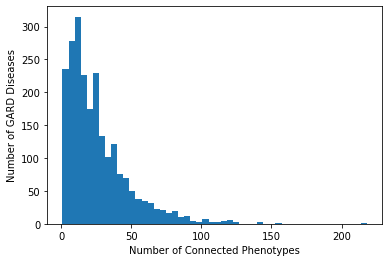

In [28]:
plt.hist(phen_df["count(s)"], bins=50)
plt.xlabel("Number of Connected Phenotypes")
plt.ylabel("Number of GARD Diseases")
plt.show()

In [30]:
phen_df.to_csv()

',d.id,n.N_Name,count(s)\n0,1,"[\'GRACILE SYNDROME\', \'FLNMS\', \'FINNISH LACTIC ACIDOSIS WITH HEPATIC HEMOSIDEROSIS\', \'FELLMAN SYNDROME\', \'GROWTH RETARDATION, AMINOACIDURIA, CHOLESTASIS, IRON OVERLOAD, LACTIC ACIDOSIS AND EARLY DEATH\', \'FINNISH LETHAL NEONATAL METABOLIC SYNDROME\', \'FELLMAN DISEASE\', \'GROWTH DELAY-AMINOACIDURIA-CHOLESTASIS-IRON OVERLOAD-LACTIC ACIDOSIS-EARLY DEATH SYNDROME\', \'GROWTH RESTRICTION-AMINOACIDURIA-CHOLESTASIS-IRON OVERLOAD-LACTIC ACIDOSIS-EARLY DEATH SYNDROME\']",16\n1,3,"[\'ABLEPHARON MACROSTOMIA SYNDROME\', \'AMS\', \'CONGENITAL ABLEPHARON, ABSENT EYELASHES/EYEBROWS, MACROSTOMIA, AURICULAR, NASAL, GENITAL AND OTHER SYSTEMIC ANOMALIES\']",49\n2,5,"[\'ABETALIPOPROTEINEMIA\', \'BASSEN KORNZWEIG SYNDROME\', \'MICROSOMAL TRIGLYCERIDE TRANSFER PROTEIN DEFICIENCY DISEASE\', \'MICROSOMAL TRIGLYCERIDE TRANSFER PROTEIN DEFICIENCY\', \'ABL\', \'ABETALIPOPROTEINEMIA NEUROPATHY\', \'APOLIPOPROTEIN B DEFICIENCY\', \'BETALIPOPROTEIN DEFICIENCY DISEASE\', \'C

In [31]:
phen_df.to_csv("GARD_Phenotype_Distribution.csv")